# Используем препроцессинг с прошлых лаб..

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('telco.csv')
data.drop(['customerID'],axis=1,inplace=True)

categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
for column in categorical_columns:
    data[column] = data[column].astype('category')

data['gender']=data['gender'].replace('Male',1)
data['gender']=data['gender'].replace('Female',0)

yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for column in yes_no_columns:
    data[column]=data[column].replace('No',0)
    data[column]=data[column].replace('Yes',1)

binary_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',  'PaperlessBilling', 'Churn']

for column in binary_columns:
    data[column] = data[column].astype('bool')

data['TotalCharges'] = data['TotalCharges'].replace(r'\s+', np.nan, regex=True)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

#print(data.dtypes)

data.dropna(inplace=True)
data = pd.get_dummies(data, categorical_columns)

for column in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    data[column] = (data[column] - data[column].mean())/data[column].std()


In [44]:
from sklearn.model_selection import train_test_split

X = data.drop(['Churn'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

# Построим классификаторы

In [45]:
def check_classifier(classifier, X_tr, y_tr, X_te, y_te):
    classifier.fit(X_tr, y_tr)

    err_train = np.mean(y_tr != classifier.predict(X_tr))
    err_test  = np.mean(y_te  != classifier.predict(X_te))

    print(f' {str(classifier)} Score on train: {1-err_train}, score on test {1-err_test}') 
    return 1-err_train, 1-err_test

### 1) Random Forest
Обучим Random Forest со стандартным знечением количества деревьев

In [46]:
from sklearn import ensemble
check_classifier(ensemble.RandomForestClassifier(n_estimators = 100), X_train, y_train, X_test, y_test)
pass

 RandomForestClassifier() Score on train: 0.9985778138967899, score on test 0.7796208530805687


Вполне ожиждаемый результат для точности на обучающей выборке. На тестовой же выборке точность соизмерима с точностью, полученной предудыщими способами. Построим график точности в зависимости от количества деревьев

 RandomForestClassifier(n_estimators=1, oob_score=True) Score on train: 0.903088175538399, score on test 0.7208530805687203
 RandomForestClassifier(n_estimators=5, oob_score=True) Score on train: 0.9697277529459569, score on test 0.75260663507109
 RandomForestClassifier(n_estimators=10, oob_score=True) Score on train: 0.9786672084518488, score on test 0.7772511848341233
 RandomForestClassifier(n_estimators=50, oob_score=True) Score on train: 0.997765136123527, score on test 0.7786729857819905
 RandomForestClassifier(n_estimators=75, oob_score=True) Score on train: 0.9985778138967899, score on test 0.7843601895734598
 RandomForestClassifier(oob_score=True) Score on train: 0.9985778138967899, score on test 0.781042654028436
 RandomForestClassifier(n_estimators=250, oob_score=True) Score on train: 0.9985778138967899, score on test 0.7800947867298578
 RandomForestClassifier(n_estimators=500, oob_score=True) Score on train: 0.9985778138967899, score on test 0.7829383886255924
 RandomForestC

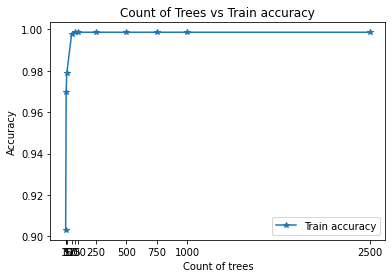

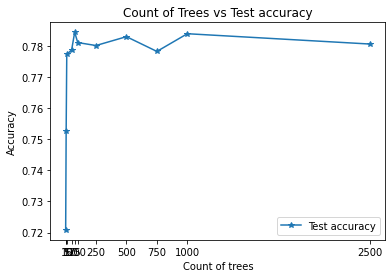

In [47]:
trees = [1,5, 10, 50, 75, 100, 250, 500, 750, 1000, 2500]
train_acc_list = []
test_acc_list = []
oob_error = []
for tree in trees:
    forest = ensemble.RandomForestClassifier(n_estimators = tree, oob_score=True)
    train_acc, test_acc = check_classifier(forest, X_train, y_train, X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    oob_error.append(1 - forest.oob_score_)

def plot(y, name):
    plt.plot(trees, y, marker='*', label=name)
    plt.title(f"Count of Trees vs {name}")
    plt.xlabel('Count of trees')
    plt.ylabel("Accuracy")
    plt.xticks(trees)
    plt.legend()
    plt.show()

plot(train_acc_list, "Train accuracy")
plot(test_acc_list, "Test accuracy")

Получилась достаточно интересная картина. Сначала у нас было недообучение (до 100 деревьев). При 100 деревьях мы достигаем максимума на тесте (на трейне упираемся в максимум) и после этого начинается переобучение: хотя качество на обучающей выборке и не увеличивается(попросту некуда), на тестовой начинает падать, что значит, что деревья стали заучивать ответы. <br>Посмотрим на oob ошибку

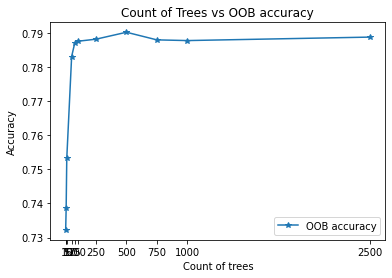

In [48]:
plot([1-v for v in oob_error], "OOB accuracy")

Out Of Bag точность в целом похожа на точность на тестовых данных. Это логчно, так как при OOB каждый объект оценивается лишь теми деревьями, что не "видели" его во время обучения, что в целом похоже на ситуацию с тестовыми объектами (их "никто" не видел). В любом случае на OOB также наблюдается падение точности, что сигнализирует о переобучении

#### Найдем значимость каждого признака 

In [105]:
rf = ensemble.RandomForestClassifier(n_estimators = 1)
check_classifier(rf, X_train, y_train, X_test, y_test)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%2d. feature '%5s' (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

 RandomForestClassifier(n_estimators=1) Score on train: 0.8986184477854531, score on test 0.7222748815165877
Feature ranking:
 1. feature 'MonthlyCharges' (0.149478)
 2. feature 'TotalCharges' (0.141538)
 3. feature 'tenure' (0.127980)
 4. feature 'PaymentMethod_Electronic check' (0.089074)
 5. feature 'Contract_Month-to-month' (0.076721)
 6. feature 'Contract_Two year' (0.056056)
 7. feature 'gender' (0.035093)
 8. feature 'PaperlessBilling' (0.031696)
 9. feature 'OnlineBackup_No' (0.027801)
10. feature 'Partner' (0.025330)
11. feature 'Dependents' (0.021157)
12. feature 'TechSupport_No' (0.019425)
13. feature 'SeniorCitizen' (0.017111)
14. feature 'StreamingMovies_Yes' (0.016541)
15. feature 'StreamingTV_Yes' (0.015152)
16. feature 'InternetService_DSL' (0.014128)
17. feature 'OnlineSecurity_Yes' (0.012851)
18. feature 'MultipleLines_Yes' (0.012755)
19. feature 'StreamingMovies_No' (0.012540)
20. feature 'MultipleLines_No' (0.012360)
21. feature 'DeviceProtection_No' (0.012153)
22. 

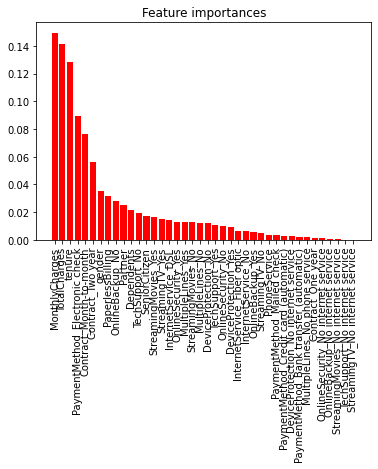

In [106]:
import matplotlib.pyplot as plt

plt.title("Feature importances")
plt.bar(range(importances.shape[0]), importances[indices], align = 'center', color = 'r')
plt.xticks(range(importances.shape[0]), X_test.columns[indices], rotation = 90)
plt.show()

В целом ничего сильного нового здесь нельзя заметить, по-прежнему наиболее влиятельными колонками остаются потраченная сумма, ежемесечнеый платеж и время, проведенное клиентом с компанией. Наличие же или отсутствие тех или иных услуг не сильно сказываются на финальном ответе. Что в целом логично и вполне объяснимо <br>
Попробуем визуализировать "верхушку" дерева


In [118]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

def vizualize_tree(tree, name):
    fn=X_test.columns
    cn=['Churn_No', 'Churn_Yes']

    export_graphviz(tree, out_file=f'{name}.dot',
                feature_names = fn, 
                class_names=cn,
                filled = True, max_depth=3, 
                impurity=False, 
                proportion=True, 
                rounded =True, 
                precision=2,
                leaves_parallel=True, label='root')

    call(['dot', '-Tpng', f'{name}.dot', '-o', f'{name}.png', '-Gdpi=600'])
    return Image(filename = f'{name}.png')

vizualize_tree(rf.estimators_[0], "RandomForest")

Первый потенциальный ответ с "расторжением" наступает в случае "Оплата электронным чеком, котракт менее двух лет, без резервных копий". В целом подходит под описание обычного клиента (не организации), ведь, скорее всего, именно они чаще всего и расторгают договоры

# 2) Gradient Boosting Tree

 GradientBoostingClassifier(n_estimators=1) Score on train: 0.7342543681430314, score on test 0.7341232227488151
 GradientBoostingClassifier(n_estimators=5) Score on train: 0.7342543681430314, score on test 0.7341232227488151
 GradientBoostingClassifier(n_estimators=10) Score on train: 0.7919544900446973, score on test 0.7824644549763033
 GradientBoostingClassifier(n_estimators=50) Score on train: 0.8228362454286875, score on test 0.7976303317535545
 GradientBoostingClassifier(n_estimators=75) Score on train: 0.8266964648516864, score on test 0.8004739336492891
 GradientBoostingClassifier() Score on train: 0.8323852092645266, score on test 0.8004739336492891
 GradientBoostingClassifier(n_estimators=250) Score on train: 0.8575782202356765, score on test 0.7914691943127963
 GradientBoostingClassifier(n_estimators=500) Score on train: 0.8931328728159285, score on test 0.7924170616113744
 GradientBoostingClassifier(n_estimators=750) Score on train: 0.9146688338073954, score on test 0.78767

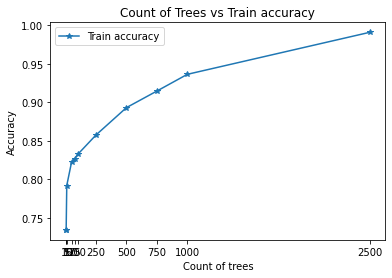

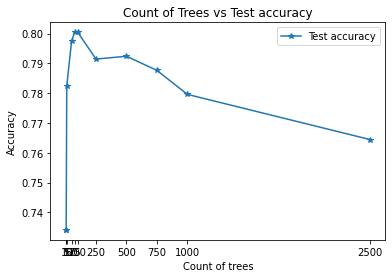

In [96]:
train_acc_list_boost = []
test_acc_list_boost = []
for tree in trees:
    forest = ensemble.GradientBoostingClassifier(n_estimators = tree)
    train_acc, test_acc = check_classifier(forest, X_train, y_train, X_test, y_test)
    train_acc_list_boost.append(train_acc)
    test_acc_list_boost.append(test_acc)


plot(train_acc_list_boost, "Train accuracy")
plot(test_acc_list_boost, "Test accuracy")

В случае с градиентным бустингом картина еще более очевидная: до 75-100 деревьев явное недообучение, после же начинается ярко выраженное переобучение(точность на трейне растет, на тесте сильно падает)

In [101]:
boost = ensemble.GradientBoostingClassifier(n_estimators = 1)
check_classifier(boost, X_train, y_train, X_test, y_test)
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_test.shape[1]):
    print("%2d. feature '%5s' (%f)" % (f + 1, X_test.columns[indices[f]], importances[indices[f]]))

 GradientBoostingClassifier(n_estimators=1) Score on train: 0.7342543681430314, score on test 0.7341232227488151
Feature ranking:
 1. feature 'Contract_Month-to-month' (0.612681)
 2. feature 'InternetService_Fiber optic' (0.184128)
 3. feature 'tenure' (0.166131)
 4. feature 'MonthlyCharges' (0.023123)
 5. feature 'TotalCharges' (0.010120)
 6. feature 'Contract_Two year' (0.003818)
 7. feature 'MultipleLines_No phone service' (0.000000)
 8. feature 'OnlineSecurity_No internet service' (0.000000)
 9. feature 'OnlineSecurity_No' (0.000000)
10. feature 'InternetService_No' (0.000000)
11. feature 'InternetService_DSL' (0.000000)
12. feature 'MultipleLines_Yes' (0.000000)
13. feature 'PaymentMethod_Mailed check' (0.000000)
14. feature 'MultipleLines_No' (0.000000)
15. feature 'OnlineBackup_No' (0.000000)
16. feature 'PaperlessBilling' (0.000000)
17. feature 'PhoneService' (0.000000)
18. feature 'Dependents' (0.000000)
19. feature 'Partner' (0.000000)
20. feature 'SeniorCitizen' (0.000000)
2

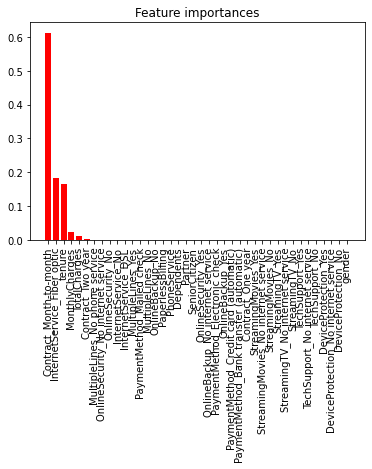

In [102]:
plt.title("Feature importances")
plt.bar(range(importances.shape[0]), importances[indices], align = 'center', color = 'r')
plt.xticks(range(importances.shape[0]), X_test.columns[indices], rotation = 90)
plt.show()

В случае со значимостью колонок в случае градиентного бустинга все оказалось несколько интереснее и немного более неожиданно. 
* На первое место вышел индикатор типа контракт (ежемесячный, годовой, 2-ухгодовой). В нашем случае именно ежемесячный. В целом это логично, что в основном расторгали контракт именно те клиенты, у кого ежемесячная оплата(а, значит, или это обычные люди и они склонны менять решение, или только-только начали сотрудничать с данной компанией и заключили догвоор на короткий период вместо сразу на год)
* На втором месте количесто месяцев с данной компанией, здесь вновь ничего нового
* На третьем вновь сюрприз - тип подключения. В данном случае интересует значение Fiber Optic - вероятно, что это самый популярный для обычных людей тип подключения, с чем и связана важность критерия

# Итог
Бустинг показал немного более лучший результат (80% на тесте), чем RandomForest (78%). Однако, разница не столько велика, чтобы однозначно сказать, что он лучше. Из изучения внутренний деталей можно сделать вывод, что в целом оба алгоритма работают одинаково эффективно с одинаковыми свойствами (примерно одинаковые значения оптимального количества деревьев, переобучение и недообучение). 
<br>
Если сравнивать эти алгоритмы с рассмотренными ранее, можно также сделать вывод, что в целом алгоритмы работают с одинаковой точностью. В случае же деревьев решений намного лучше и выше интерпретируемость. Такое значение точности скорее всего обсусловленно датасетом (попытки борьбы с которым были выплнены в первой лабораторной работе)